# What Impacts a Student's Grades?

This notebook involves a full analysis of the UCI Student Performance dataset, which consists of the democraphics and resulting grades for 600+ students in two Portugese schools. A link to the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/student+performance).

This notebook is divided into three main sections:

1. Exploratory Data Analysis

2. Machine Learning Model Training

3. Final Conclusion

The first two sections will be based on the question: What does or does not impact a student's grades, and to what extent?

In the third section, based off of the information from the first two sections, we will summarize our findings and make a claim on how schools can sufficiently improve the grades of their students.

### Part 1: Exploratory Data Analysis

We'll start off by just importing all of the neccessary libraries(there's a lot) and loading the data. Specifically, our data consists of 649 students and their respective grades in their Portugese class. Although the UCI dataset also includes the student's grades in Mathematics, ~40% of the students in the dataset do not take the class. Because we want a more uniform, standardized measurement of a student's acedemic success, we will not use the math data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import plot_tree
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from scipy import stats
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mlxtend.evaluate import paired_ttest_5x2cv
plt.style.use("ggplot")

In [2]:
df = pd.read_csv("student-por.csv", sep=';')
print(df.shape)
print(df.head())

(649, 33)
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]


A notable component of this dataset is that it has a high number of features for its size - 33 features for a dataset of only 649 instances. This means we'll have to deal with the Curse of Dimensionality - problems arising when dealing with high dimensional data - throughout this notebook.

Because the categorical features in the dataset consist of Strings, our next step is transform them to numbers, which we will use a Label Encoder for(Assigning each unique String a number). We will NOT use One Hot Encoding(Converting each String to a vector consisting of bits) due to the previously mentioned issue of high dimensionality.

In [3]:
col2class = {}
df_encoded = df.copy()

for col in df.columns:
  if df.dtypes[col] == object:
    encoder = LabelEncoder().fit(df[col])
    col2class[col] = list(encoder.classes_)
    df_encoded[col] = encoder.transform(df[col])

print(col2class)
print(df_encoded)

{'school': ['GP', 'MS'], 'sex': ['F', 'M'], 'address': ['R', 'U'], 'famsize': ['GT3', 'LE3'], 'Pstatus': ['A', 'T'], 'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'Fjob': ['at_home', 'health', 'other', 'services', 'teacher'], 'reason': ['course', 'home', 'other', 'reputation'], 'guardian': ['father', 'mother', 'other'], 'schoolsup': ['no', 'yes'], 'famsup': ['no', 'yes'], 'paid': ['no', 'yes'], 'activities': ['no', 'yes'], 'nursery': ['no', 'yes'], 'higher': ['no', 'yes'], 'internet': ['no', 'yes'], 'romantic': ['no', 'yes']}
     school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  ...  \
0         0    0   18        1        0        0     4     4     0     4  ...   
1         0    0   17        1        0        1     1     1     0     2  ...   
2         0    0   15        1        1        1     1     1     0     2  ...   
3         0    0   15        1        0        1     4     2     1     3  ...   
4         0    0   16        1        0       

Through our analysis, we will intepreting how certain features affect the G3 variable and to what extent. Therefore, we need to know how the distribution of grades looks like: we can use a histogram to figure that out:

11.906009244992296 3.230656242804805


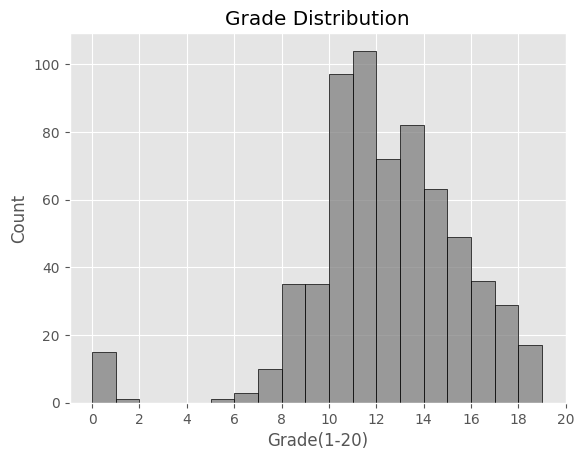

In [4]:
print(df["G3"].mean(), df["G3"].std())

h = sns.histplot(df["G3"], color='grey', edgecolor='black', binwidth=1)
h.set_xticks(range(0, 21, 2))
plt.xlabel("Grade(1-20)")
plt.title("Grade Distribution")
plt.show()

We can see here that most of the student's grades are concentrated around at the 10 - 14 section, and it is moderately spread out(3.23 std). Although the amount of 0's does skew the distribution a little bit, it is still roughly normal. This is important, as it shows that we do NOT need to fix the skewness of our distribution before applying ML algorithms.

Also, despite Linear Regression being sensititive to outliers, we will NOT remove the students which have a grade of 0 from our dataset, because the data they hold may be valuable for our analysis.

Now, we will split the data into X(features) and y(target variable) to prepare for data analysis. Because we are trying to look only for which variables influence a student's grades, we will remove all other features directly relating to grades: Specifically, G1(grades for semester 1) and G2(grades for semester 2) will be removed, only leaving G3(overall grade) for the target variable.

In [5]:
X = df_encoded.drop(["G1", "G2", "G3"], axis=1)
y = df_encoded["G3"]

print(X.shape, y.shape)

(649, 30) (649,)


Linear Regression estimates, for each predictor variable, a coefficient that measures its independent effect on the target variable. More specifically, the coefficient represents the change in the target variable when increasing this variable by 1 unit while holding all other variables constant. These coefficients are often used for data analysis due to this "controlling property".

 However, when a predictor variable is highly correlated with other predictor variable(s), Linear Regression doesn't know how to measure the variable's independent effect on the target, and overfits.

In order to account for this, we will take note of all variables that are highly correlated by utilizing the Variance Inflation Factor(VIF). This measures the degree of multicollinearity of a predictor variable on all other variables. A VIF > 5 for a given variable means that it is highly correlated with other variables, and we will find the variables that fit this in the dataset:

In [6]:
vifs = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
corr_features = [f for f, v in zip(X.columns, vifs) if v > 5]

print(len(corr_features))
print(len(X.columns))

16
30


That is quite a lot of correlated features - over 50% of the features have multicollinearity. However, when looking at the features themselves(e.g. Age, Daily Alchohol Consumption, Weekly Alchohol Consumption) this isn't really surprising. We will consider this when conducting our analysis.

We will now train the Linear Regression model and get its coefficients. We'll also get the R2 score(Percentage of variability of the target variable explained by the predictor variables), however due to the high prescence of multi-collinearity it will not be very accurate.

In [7]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression().fit(X, y)

coefs = linear_model.coef_

print(r2_score(y, linear_model.predict(X)))

0.3454006684327243


Based on the whole dataset, 34.5% of the variability in student's grades can be explained by the features of the dataset. During Section 2, we'll compare this to the model's performance on testing data to see if it's accurate.

There are a couple of assumptions we have to make for our regression model before  analyzing its coefficients. One of these assumptions is that the residuals are normally distributed.

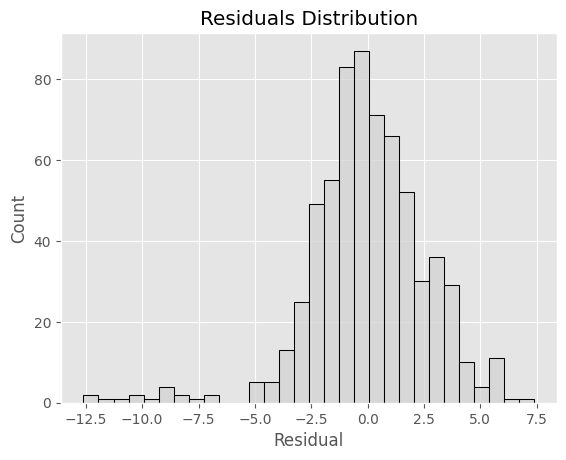

In [8]:
residuals_linear = y - linear_model.predict(X)

sns.histplot(x=residuals_linear, color='lightgrey', edgecolor='black', linewidth=0.75)
plt.xlabel("Residual")
plt.title("Residuals Distribution")
plt.show()

Based on this graph, we can see that excluding a few outliers, the residuals do follow a roughly normal distribution.

Another assumption Regression analysis makes is homoscedasticity, which essentially means that the spread of the model's residuals does not depend on the model's predicted values.

We'll plot the residual plot for our model to see if it follows this assumption:

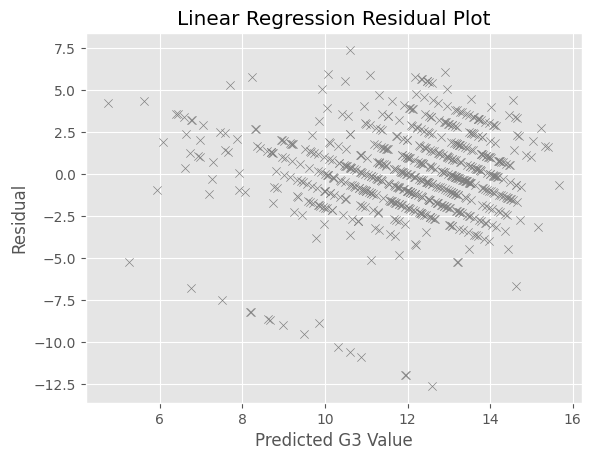

In [9]:
sns.scatterplot(x=linear_model.predict(X), y=residuals_linear, color='grey', marker='x', legend=None)
plt.xlabel("Predicted G3 Value")
plt.ylabel("Residual")
plt.title("Linear Regression Residual Plot")
plt.show()

Our residual plot shows not only outliers in residuals but also that the spread of the residuals is dependent on the predicted G3 Value. There is a clear pattern that can be seen in the plot, indicative that the current model is heteroscedastic.

One solution for heteroscedasticity is to use Weighted Linear Regression, which assigns weights to each observation when training the model. The weights are assigned such that highly varied obserations(observations w/ higher absolute residuals) are given less weight and vise-versa, in order to make the variabilities more even.

We'll test this model and see the resultant residual plot.

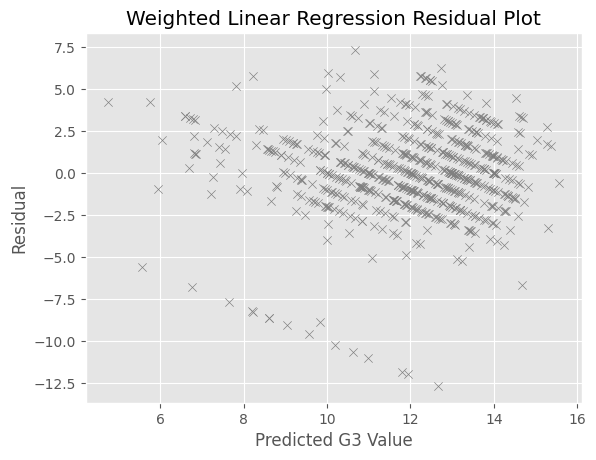

In [10]:
weights = 1 / residuals_linear**2

weighted_lr = LinearRegression().fit(X, y, sample_weight=weights)
residuals_weighted = y - weighted_lr.predict(X)

sns.scatterplot(x=weighted_lr.predict(X), y=residuals_weighted, color='grey', marker='x', legend=None)
plt.xlabel("Predicted G3 Value")
plt.ylabel("Residual")
plt.title("Weighted Linear Regression Residual Plot")
plt.show()

The resultant plot shows that WLR did not make much of an impact on the residuals showcasing a pattern. The model is still heteroscedastic.

A final solution is to simply change which regression model to use. In particular, we can use Robust Linear Regresison, a type of regression  that does not assume homoscedasticity. An extra bonus is that Robust Regression is also more resilient to outliers, something visibly present in our data.

Huber Regression is an example of a Robust Regression model, so we will use it instead.

In [11]:
from sklearn.linear_model import HuberRegressor

linear_model = HuberRegressor(max_iter=10000).fit(X, y)

coefs = linear_model.coef_

print(r2_score(y, linear_model.predict(X)))

0.33104930551488354


Unsurprisingly, the R2 Score is very similar to Linear Regression's. The model also likely overfit on the data due to the presence of multicollinearity.

Now that our assumptions are met, we can now analyze the coefficients of the model. However, we'll also need to see whether each coefficient is statistically significant or not, so we will find the p-values first.

In this case, the null hypothesis for each predictor variable is that the target variable(Grades) does NOT change significantly when the predictor variable changes. Each p-value measures the probability that, given the null hypothesis is true, we would observe a coefficient as or more "extreme" as the actual coefficient.

The significance level we choose will be 0.05, meaning that there is a 5% risk whenever we reject the null hypothesis that the null hypothesis is actually true(Also known as Type I Error). In other words, if the p-value is < 0.05, we will reject the null hypothesis.

In [12]:
import statsmodels.api as sm

X2 = sm.add_constant(X)
est = sm.RLM(y, X2, M=sm.robust.norms.HuberT())
est2 = est.fit()
print(est2.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                     G3   No. Observations:                  649
Model:                            RLM   Df Residuals:                      618
Method:                          IRLS   Df Model:                           30
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 21 Jun 2023                                         
Time:                        00:45:45                                         
No. Iterations:                    19                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6218      1.653      4.006      0.0

With these p-values in mind, we'll graph the coefficients and note the multicollinear features. First though, we will have to remove all the multi nominal features(Features which have more than 2 unique values not in any order) from the graph, as we can't properly interpret their coefficients.

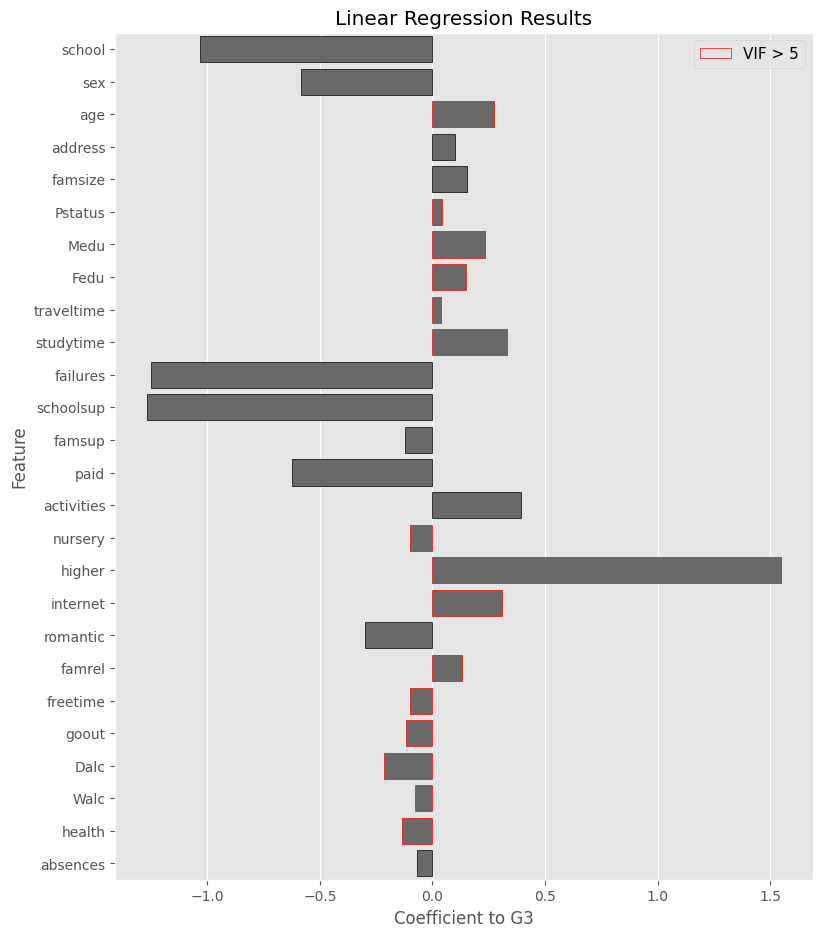

In [13]:
col2coef = {X.columns[i]: coefs[i] for i in range(len(coefs))}

multi_nominal = [col for col, classes in col2class.items() if len(classes) > 2]

other_cols = [col for col in X if col not in multi_nominal]
other_coefs = [col2coef[col] for col in other_cols]
colors = ["black" if c not in corr_features else "red" for c in other_cols]

plt.figure(figsize=(9, 11))
sns.barplot(y=other_cols, x=other_coefs, color='dimgray', edgecolor = colors)
plt.legend([plt.Rectangle((0, 0), 1, 1, fc='none', ec='r')], ["VIF > 5"], loc="upper right", fontsize=11)
plt.xlabel("Coefficient to G3")
plt.ylabel("Feature")
plt.title("Linear Regression Results")
plt.show()

Although we can't properly intepret the coefficients of the multicollinear variables, for the ones that aren't, we get some interesting results:

- Being a male instead of female, even when controlling for other variables such as desire for higher education and educational support, results in a -0.5 deducation for the student's predicted grade, a statistically significant coefficient(p-value < 0.05). We know that intelligence is irrespective of gender, so this shows how there are other features not covered in this dataset that cause this.

- Oddly, getting provided educational support from a school results in a student's predicted grade decreasing by around -1.25, and this is statistically significant(p-value < 0.05). Although one might argue that this is because student's recieve school support because they have done worse acedemically, this coefficient arises even after controlling for a student's past failures. Given that this dataset is from only two Portugese schools, their school support system may be flawed.

- There is also not sufficient data to conclude that family educational support or getting paid classes actually impacts a student's grades(both p-values are > 0.05), even when controlling for failures and desire for college education. This shows that improving a student's grades goes beyond simply "more education".

- A student's absences are, rather obviously so, very impactful to grades(p-value < 0.05). Specifically, each 7 absences a student has results in their predict grade dropping ~0.50 points, a significant drop when compared to the coefficients of the features.

Now, what can we infer from all of those features that are correlated with other variables? A good step in answering this question is looking at which other variables these features are associated with.

In [14]:
corr_matrix = X[corr_features].corr()

for corr_f in corr_features:
  if corr_f not in multi_nominal:
    corrs = dict(corr_matrix[corr_f])
    corrs = dict(sorted(corrs.items(), key = lambda x: x[1], reverse = True)[1:4])

    print(corr_f)
    print(corrs)
    print()

age
{'Dalc': 0.13476826838640513, 'goout': 0.11280462078676545, 'Walc': 0.08635734514165765}

Pstatus
{'Walc': 0.0709763877865484, 'internet': 0.05975402331960704, 'Fjob': 0.05430550373157953}

Medu
{'Fedu': 0.6474766091364943, 'internet': 0.26605229807955266, 'higher': 0.2138963187215236}

Fedu
{'Medu': 0.6474766091364943, 'Fjob': 0.21160381838886966, 'higher': 0.19173539497718745}

traveltime
{'Dalc': 0.09282428355692025, 'goout': 0.05745419566943, 'Walc': 0.05700717799788846}

studytime
{'higher': 0.18825573167968218, 'Medu': 0.09700583290488128, 'Fedu': 0.05039964766444921}

nursery
{'Medu': 0.12595132576702953, 'Fedu': 0.07486264396343792, 'studytime': 0.042629800673668075}

higher
{'Medu': 0.2138963187215236, 'Fedu': 0.19173539497718745, 'studytime': 0.18825573167968218}

internet
{'Medu': 0.26605229807955266, 'Fedu': 0.18348267151922856, 'goout': 0.09286895547533199}

famrel
{'freetime': 0.12921567655885208, 'health': 0.10955921666418504, 'goout': 0.08970656912926568}

freetime


These results show that the reason so many variables are multicollinear is simply because there are other very similar variables in this dataset. Notable examples are Daily alchohol consumption with Weekly alchohol consumption and Mother's Education with Father's education, although other examples also exist such as health status' correlation with alchohol consumption and family relationship quality.

This means that although we can't conclude how these features individually affect grades, we can make accurate, general statements abou them:

- Dedication to school is by far the most positively impacting factor when it comes to a student's grades. This is shown through higher(the student wanting to pursue college) having a very high coefficient(~1.5), and higher being correlated with family education and studying commitment. Although the p-value for higher is < 0.05, we can't fully trust this p-value as higher is a multicollinear variable(lower statistical power --> p-values pushed down). However, because of how high the coefficient is, this relationship is highly likely to not be a coincidence.

- There is no sufficient data in this dataset to prove that, when controlling for dedication to school, the amount of free time a student spends negatively impacts their grades. This is proven by the variables freetime and goout(both correlated with eachother) having p-values > 0.05(despite the lower statistical power caused by multicollinearity).

It's important to note that the p-values of the features in this dataset being > 0.05 doesn't mean that those features have no affect on a student's grades in real life. It just means that based on this dataset, we cannot conclude with a < 5% Type I error risk that the feature affects a student's grades. However, being able to compare the features we can reject the null hypothesis and those we can't gives us valuable information.

While we do know the controlled impacts of the features on the student's grades, it could also be useful to see how controlling these features impacted their coefficients. Here, we could classify features as either having a direct effect on grades(at least, based off of the features accounted for in this dataset), an indirect effect on grades, or no effect on grades.

In order to do this, we will plot a graph in which we compare, for each feature, the coefficient of a Single Linear Regression between the feature and grades with the overall "controlling" coefficient:


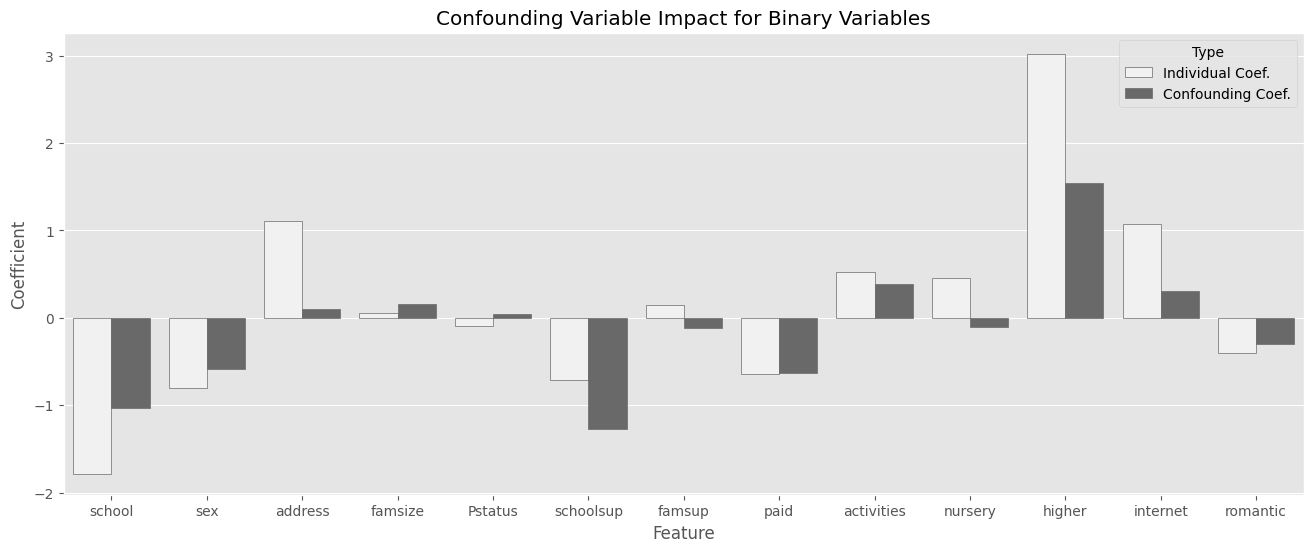

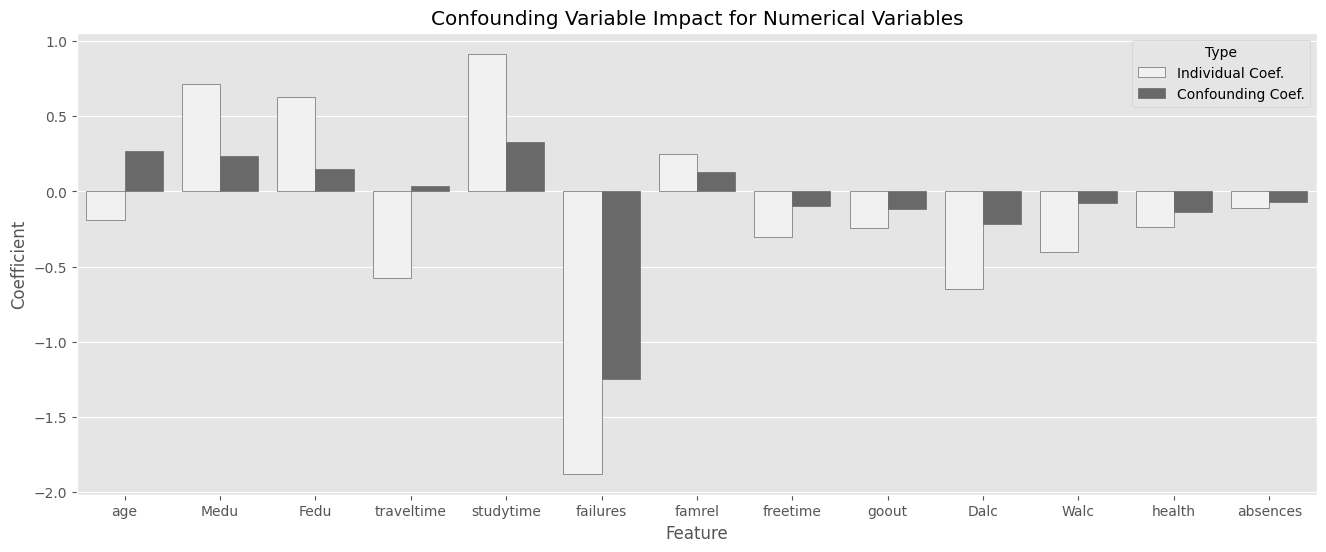

In [15]:
def dif_mean(col):
  single_reg = HuberRegressor().fit(np.array(X[col]).reshape(-1,1), y)
  coef = single_reg.coef_[0]
  return coef

binary = [col for col in col2class.keys() if len(col2class[col]) == 2]
numerical = [col for col in X.columns if col not in binary and col not in multi_nominal]

def plot_coef_dif(all_cols, title):
  difs = [dif_mean(col) for col in all_cols]
  binary_coefs = [col2coef[col] for col in all_cols]

  temp_df = pd.DataFrame({
      "Feature":all_cols,
      "Individual Coef.":difs,
      "Confounding Coef.":binary_coefs
  })
  temp_df = pd.melt(temp_df, id_vars="Feature")
  temp_df = temp_df.rename(columns={"variable": "Type"})

  plt.figure(figsize=(16,6))
  sns.barplot(x="Feature", y="value", hue="Type", data=temp_df, color="dimgrey", edgecolor = "dimgray")
  plt.ylabel("Coefficient")
  plt.title(title)
  plt.show()

plot_coef_dif(binary, "Confounding Variable Impact for Binary Variables")
plot_coef_dif(numerical, "Confounding Variable Impact for Numerical Variables")

Based off of this graph, we can see which features actually have an effect on a student's grades and which features have an indirect effect. However, in order to truly analyze it, we need to see which features specifically are causing the confounding coefficient to change for every feature.

For every feature, we will compare the Single Linear model coefficient with the same coefficient after including a second variable. This nested for loop will run for every single feature, and whenever adding another variable has a >= 20% influence on the coefficient, it will be noted as a confounding variable.

In [16]:
def percent_dif(mean0, mean1):
  p = (100*mean1 - 100*mean0) / mean0
  return p

def confounding_variable_impact(col, confound_col):
  reg_mean = dif_mean(col)
  multi_reg = HuberRegressor().fit(X[[col, confound_col]], y)
  coef_col = multi_reg.coef_[0]

  return percent_dif(reg_mean, coef_col)

all_cols = binary + numerical
col2confounding = {col: {} for col in all_cols}
col2veryconfounding = {col: {} for col in all_cols}

for col in all_cols:
  for feature in all_cols:
    if feature != col:
      impact = confounding_variable_impact(col, feature)
      if abs(impact) >= 20:
        col2confounding[col][feature] = impact

for col, the_dict in col2confounding.items():
  if len(list(the_dict.keys())) > 0:
    print(col)
    print(the_dict)
    print()



school
{'Medu': -23.09043103553445}

sex
{'Medu': 24.572915536773035, 'studytime': -36.26715235524423, 'failures': -23.710843042969135, 'Dalc': -42.711801305596445, 'Walc': -39.79770706876399}

address
{'school': -54.2911314242081, 'higher': -23.50954389474575, 'Medu': -29.829731631857705, 'traveltime': -20.79883399263128}

famsize
{'school': 33.201570217592206, 'sex': 226.66618303858525, 'address': -238.171718204843, 'Pstatus': -23.86156138221787, 'schoolsup': -35.456462894252894, 'paid': -34.809774027152955, 'nursery': -50.906910431223004, 'higher': -23.87050611703099, 'internet': -46.07019312899599, 'Fedu': 81.13712628370801, 'traveltime': -102.70643287205498, 'studytime': 105.02103686300362, 'failures': -124.73114499098016, 'famrel': -33.1790278510025, 'freetime': -28.09441833185901, 'goout': -25.1924915107876, 'Dalc': 318.6623814739903, 'Walc': 339.3865448711116, 'absences': 84.92456171931912}

Pstatus
{'school': -74.7198727400955, 'sex': -101.36324040457232, 'address': -193.90905

Based off of these results and the preceding graph, we can make the following observations:

- Although it might seem like being from an urban rather than rural neighbor positively impacts student's grades(address variable), when accounting for the differing urban vs rural rates of school districts, this impact dimishes to practically 0. The school that a student goes to matters significantly more than whether they're from an urban or rural area.

- Surpisingly, when accounting for the school a student goes to or the educational level of a student's parents, a student having internet access at home has a much smaller effect on their grades.

- Age actually transforms from being negatively related to grades to positively related(although, based off of correlated features, it would make more sense to brand age as "maturity"). This occurs after controlling for the number of failures.

- A student going out matters a lot less when controlling for alchohol consumption. This means that having free time and going out isn't neccessarily negative to a student's acedemic success, as long as they don't spend it doing harmful activities.

One relationship that could potentially give us useful information is the relationship between age and grades. When accounting for failures, age transforms from a negative to positive relationship with grades. We'll look through a graph to understand why.

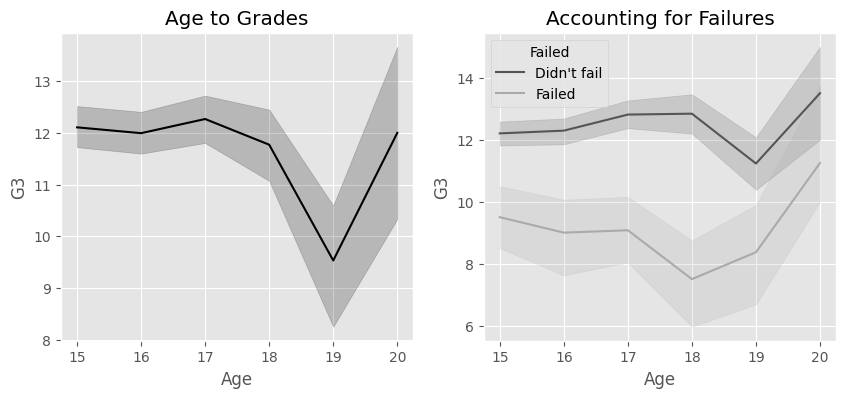

In [17]:
df["Failed"] = df["failures"].apply(lambda x: "Failed" if x > 0 else "Didn't fail")

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(ax=ax[1], x="age", y="G3", hue="Failed", data=df[df['age'] < 21], palette="gray")
sns.lineplot(ax=ax[0], x="age", y="G3", data=df[df['age'] < 21], color='black')
ax[0].set_xlabel("Age")
ax[1].set_xlabel("Age")
ax[0].set_title("Age to Grades")
ax[1].set_title("Accounting for Failures")
plt.show()
df = df.drop("Failed", axis=1)

Based off of the graph, we can see how initially it appears that grades significantly drop from 18-19 years old for students, before increasing afterwards. However, based off of the right graph, students with past failures actually face this drop from 17-18 years of age, while students with none face this from 18-19 years of age.

A notable educational event occuring for students at 18 years old is a shift to college. Only certain students with past failures are actually going to go to college, and those students are likely more equipped to deal with past setbacks and more determined to complete college, which is why their grades steadily increase throughout all of higher education. The drop from 17-18 years of age may just be students who don't want to go to higher education giving up senior year.

Students without past failures, on the other hand, are not equipped to deal with setbacks, which a harder college may put: this explains the drop once these students start college.

Another relationship we'll check is how alchohol consumption when going out influences grades, and we will again do this through a side-by-side line graph.

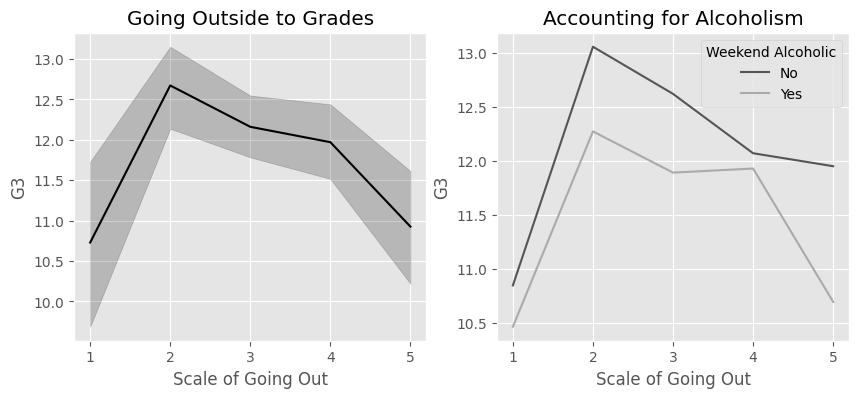

In [18]:
df["Weekend Alcoholic"] = df["Walc"].apply(lambda x: x > 1).map({False: "No", True: "Yes"})

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(ax=ax[1], x="goout", y="G3", hue="Weekend Alcoholic", data=df[df['age'] < 21], palette="gray", errorbar=None)
sns.lineplot(ax=ax[0], x="goout", y="G3", data=df[df['age'] < 21], color='black')
ax[0].set_xlabel("Scale of Going Out")
ax[1].set_xlabel("Scale of Going Out")
ax[0].set_title("Going Outside to Grades")
ax[1].set_title("Accounting for Alcoholism")
plt.show()
df = df.drop("Weekend Alcoholic", axis=1)

Although initially it may seem as if going outside drops student's grades, when controlling for alchoholism, this drop becomes a bit more complicated. Students who are not alchoholics see a noticeable drop of grades from the scale of 2-4 before leveling off at 5. However, students who are alchoholics significantly drop their grades once they reach the 5 scale.

The reason going out generally negatively affects grades likely has to do with students who go out more caring less about school(note how the  coefficient for going out becomes 30% less significant when accounting for studying time). However, extreme events during going out like drinking excess alchohol make this relationship worse.

Other than Regression analysis, another method for data analysis is looking at a Decision Tree chart. Decision Trees are a type of ML algorithm which use decisions based off of features to predict data. In short, they run through a list of potential splits they can make off of the data, and whichever split results in the highest purity(the resultant groups are the most different from one another) will be the accepted one. The split will be made, and the process will continue. As a result, at the end of this process, the most purifying(important) splits will be at the top of the decision tree, and they will get more specific and less important as the tree increases in depth. Also, due to the nature of these comparisons, Decision Trees require little data preparation - there is no need for scaling, ensuring no multicollinearity, etc.

A powerful aspect of Decision Trees are that they can capture non-linear relationships between data, unlike linear regression. By taking a look at Decision Trees, deeper inferences can be made about the data. In this case, we'll look at a Decision Tree with a depth of 3 which attempts to predict a student's grades off of all of the features. We'll also make the minimum of samples per leaf(a leaf being a final prediction) 10 so that the Decision Tree doesn't overfit off of very limited data.

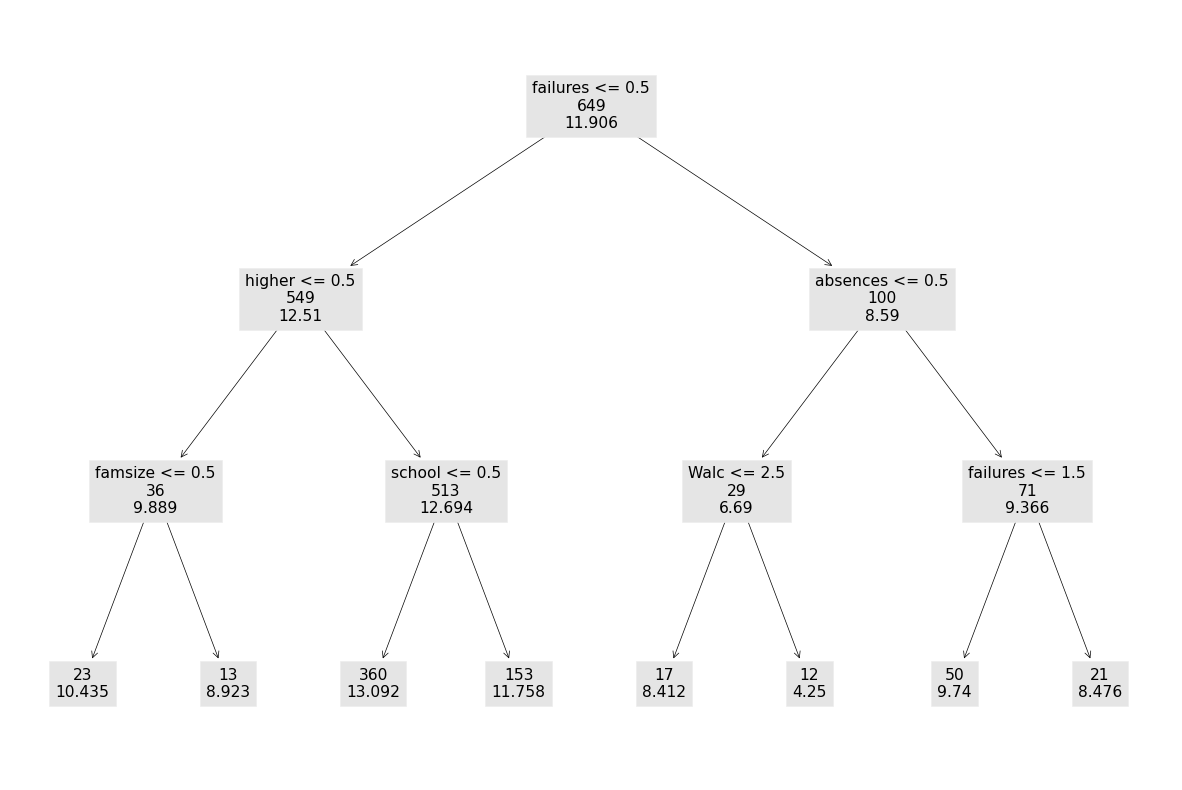

In [19]:
dt_3 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=10).fit(X, y)
plt.figure(figsize=(15,10))
_ = plot_tree(dt_3, feature_names=X.columns, label=None, impurity=False)

One variable to no surprise stands out from this tree: failures, clearly the most important variable when predicting a student's grades. Although the tree looks relatively normal, one interesting aspect of it is how the tree deals with absences. While the Linear Regression model portrayed a strong negative relationship between a student's absences and grades, for this tree, students who have had failures and have had > 0 absences are given greater average predicted grades than students who have had failures but 0 absences. This shows that absences may not have a complete, linearly negative impact on grades.

# Section 2: Machine Learning

We will use multiple Machine Learning algorithms to test how well a model can predict a student's grades given the demographics and past information about the student, as well as get some other information on the features.

To start off, we will split our data into training and testing datasets. Although the models will be evaluated through cross validation on the training set, the testing set is essential to make sure under new data the models still work well.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(519, 30) (519,)
(130, 30) (130,)


For this section, we will test four ML algorithms other than Linear Regression:

1. Support Vector Regression: Instead of Linear Regression, which attempts to fit a line on the data to minimize the residuals, an SVR attempts to fit a hyperplane on the data that can both fit the data points well and can maximize a distance known as the margin. The margin is the distance between the hyperplane and its closest data points(known as support vectors, as they essentially define what the hyperplane ends up being). A key feature of Support Vector Machines is kernels: these can be used to find a hyperplane in a higher dimension and "broadcast" it back to the lower dimension, allowing SVMs the ability to capture non-linear relationships. Due to SVM's kernel trick and their general superior performance on limited data(such as this dataset), we will test an SVR.

2. Random Forest Regression: This is a modification of the Decision Tree algorithm that instead train a significant amount of small Decision Trees(known as weak learners) on random subsets of data. From there, given new data to predict off of, the Random Forest will take the mean of all of the weak learners' predictions and predict that. Random Forests generally perform well, and as such we will test them.

3. Gradient Boosting Regression: This is similar to Random Forests, except the weak learners are trained one at a time: the first weak learner is trained off of the data, and then based on what the learner got wrong, the data is modified before sending it off to the second weak learner to ensure that the second weak learner gets those wrongfully predicted data points correct. These also perform well, which is why we will test them, although it is important to note they are more prone to overfitting.

4. XGBoosting Regression: XGBoost is very similar to Gradient Boosting, except it focuses more on regularization(combatting overfitting). Due to it solving a pretty big issue Gradient Boosting has, it performs well, and we will use it.

There are two practices we're going to perform on the dataset: K-fold cross validation and grid searching.

K-folds is a method of estimating the accuracy of a dataset which splits the given dataset into k splits, and for each split, trains the given model on the rest of the splits and obtains the accuracy for that split. After each split's respective accuracy is obtained, K-folds returns the average. K-folds is superior to the regular training-testing method for getting a model's accuracy as it prevents selection bias.

Grid Searching is the process of using given data to find the best-performing parameters for a model, given a set of parameters to test. GridSearchCV in particular does this by using K-fold cross validation to test the accuracy of every parameter given, and returning the parameter which performs the best.

We will use Grid searching on all 4 of these models to try and get their highest performing version. For the SVR, we will optimize the C parameter, which dictates how "hard" the hyperplane will attempt to fit on the training set. The larger the C value, the smaller the margin will be, making the SVR fit better on the training set but more prone to overfitting. For the other tree-best models, we will just optimize how many weak learners will be present.

In [21]:
def best_params(alg, params, scale=False):
  search = GridSearchCV(
      alg,
      params,
      cv=10,
      scoring="neg_root_mean_squared_error",
      verbose=1
  )

  if scale:
    search.fit(StandardScaler().fit_transform(X_train), y_train)
  else:
    search.fit(X_train, y_train)
  return search.best_params_, search.best_score_

print(best_params(SVR(), {'C': [0.001, 0.01, 0.1, 1, 10]}, True))
print(best_params(RandomForestRegressor(), {'n_estimators':[50, 100, 500]}))
print(best_params(GradientBoostingRegressor(), {'n_estimators':[50, 100, 500]}))
print(best_params(XGBRegressor(), {'n_estimators':[50, 100, 500]}))

Fitting 10 folds for each of 5 candidates, totalling 50 fits
({'C': 1}, -2.768691874729957)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
({'n_estimators': 500}, -2.78467240014053)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
({'n_estimators': 50}, -2.8483518397224983)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
({'n_estimators': 100}, -3.0245737410093305)


Unsurpisingly, the parameters didn't influence the accuracies much in this small dataset - only the SVM and Gradient Boosting's parameter changed from the default, and minorly so. We'll compare these RMSE values with the Linear Regression one to see if they perform any differently.

Although we can see the RMSE for each best-performing model, it would also be useful to get its standard deviation as well as the list of the cv results. Rather than just using a 10-fold cross validation method, we will also sample each cv 10 times so we can obtain 100 samples for each model, making the analysis on each model's performance more accurate.

In [22]:
sv_model = SVR(C=1)
rf_model = RandomForestRegressor()
gb_model = GradientBoostingRegressor(n_estimators=50)
xg_model = XGBRegressor()

def mean_std_cv(model, times, train_data):
  all_scores = []

  for i in range(times):
    scores = np.abs(cross_val_score(model, train_data, y_train, cv=10, scoring='neg_root_mean_squared_error'))
    all_scores += list(scores)

  all_scores = np.array(all_scores)
  print(all_scores.mean(), all_scores.std())
  return all_scores, all_scores.mean(), all_scores.std()

cv_lr, m_lr, s_lr = mean_std_cv(LinearRegression(), 10, StandardScaler().fit_transform(X_train))
cv_sv, m_sv, s_sv = mean_std_cv(sv_model, 10, StandardScaler().fit_transform(X_train))
cv_rf, m_rf, s_rf = mean_std_cv(rf_model, 10, X_train)
cv_gb, m_gb, s_gb = mean_std_cv(gb_model, 10, X_train)
cv_xg, m_xg, s_xg = mean_std_cv(xg_model, 10, X_train)

2.835527527519279 0.5218322226810108
2.768691874729957 0.5387471537240225
2.805282018944838 0.5048551000166589
2.8500048499630877 0.4994449065039427
3.0245737410093305 0.5248352998599399


First of all, we can see that the RMSE values for all the other ML models have little differences to the Linear Regression one. We can also see that the standard deviations for each model are quite large: ~0.50 for a mean of just ~2.8. This is likely due to the small dataset given and the general lack of accuracy the models have, making the performance on the training-testing split for each sample highly dependent on the specific split.

A common way of seeing how the model would perform on unseen data is to use confidence intervals: given a % confidence, one can assess the range of accuraries that the model would have on unseen data. For each model, we will use a 95% confidence.

In [23]:
def confidence(level, samples, mean, std):
  z_score = stats.norm.ppf((1 + level) / 2)
  moe = z_score * (std/np.sqrt(samples))
  return str(mean - moe) + " - " + str(mean + moe)

print("Linear Regression: " + confidence(0.95, 100, m_lr, s_lr))
print("SVM: " + confidence(0.95, 100, m_sv, s_sv))
print("Random Forest: " + confidence(0.95, 100, m_rf, s_rf))
print("Gradient Boosting: " + confidence(0.95, 100, m_gb, s_gb))
print("XGBoost: " + confidence(0.95, 100, m_xg, s_xg))

Linear Regression: 2.733250291276552 - 2.9378047637620055
SVM: 2.663099372922702 - 2.874284376537212
Random Forest: 2.7063322376004364 - 2.90423180028924
Gradient Boosting: 2.7521154470621174 - 2.947894252864058
XGBoost: 2.9217079124552545 - 3.1274395695634065


We can see that although each model generally has similar ranges, there are slight differences, especially for the XGBoost.

In order to know whether the differences between the model's ranges occured purely by chance or are actually meaningful, we can use a t-test. A t-test verifies, given two distributions, whether the difference between the means of the distributions is statistically significant or not. In particular, the t-test returns the p-value(where the null hypothesis is that the differences between the means are virtually the same), which we will utilize here with a 95% confidence.

The type of t-test we'll use is a 5x2 paired t-test. For each model, this t-test gets its accuracy distribution by running 5 runs of 2-fold cross validation(each split on the dataset random). This is generally recommended over just a 10-fold t-test as the 10-fold test has high Type I error.

In this case, we will use the 5x2 t-test to compare Random Forests with each of the other algorithms, as the Random Forest performed well with a slightly less standard deviation. We will hold a 95% confidence, only rejecting the null hypothesis if the p-value < 0.05.

In [24]:
def get_p_value(model1, model2, scale=False):
  train_data = X_train.copy()
  if scale: train_data = StandardScaler().fit_transform(train_data)

  t, p = paired_ttest_5x2cv(estimator1=model1,
                            estimator2=model2,
                            X=train_data,
                            y=y_train,
                            scoring='neg_root_mean_squared_error',
                            random_seed=0)
  return p

print(get_p_value(rf_model, LinearRegression(), True))
print(get_p_value(rf_model, gb_model))
print(get_p_value(rf_model, sv_model, True))
print(get_p_value(rf_model, xg_model))

0.8274677498790584
0.5359466798504997
0.24634004197429146
0.04772036589880113


Based off of these results, we can conclude with a 95% confidence that the XGBoost model's worse performance on the dataset is not simply due to chance. This is likely because of the small dataset given: when it comes to small datasets, it is preferrable to have high variance over high bias, and XGBoost's regularization feature may have went overboard in this aspect. However, for the rest of the ML models(including Linear Regression!), the differences in their accuracies cannot be concluded to be statistically significant.

From now on, we will not analyze the XGR's performance. But for the rest of the models, we will start off by making a box plot for each of the cross validation results to see any noteable differences.

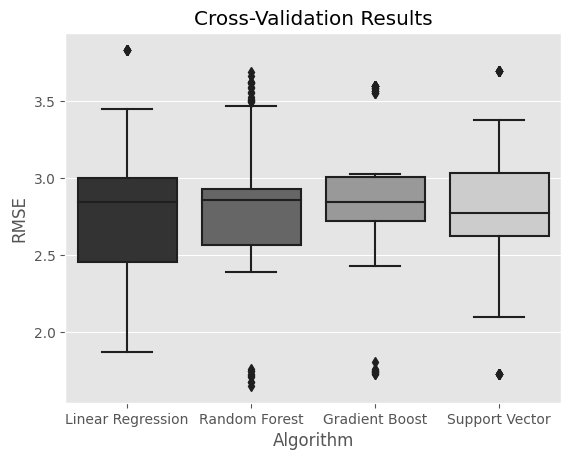

In [25]:
all_scores = list(cv_lr) + list(cv_rf) + list(cv_gb) + list(cv_sv)
algos = ["Linear Regression" for i in range(10*10)] + ["Random Forest" for i in range(10*10)] + ["Gradient Boost" for i in range(10*10)] + ["Support Vector" for i in range(10*10)]

sns.boxplot(x=algos, y=all_scores, palette="gray")
plt.xlabel("Algorithm")
plt.ylabel("RMSE")
plt.title("Cross-Validation Results")
plt.show()

We can see here that although each of the algorithms are very similar, Linear Regression has more variability(wider box) in its accuracies but less outliers, while the tree-based algorithms had less variability with more outliers.

Support Vector Machines are powerful with limited amounts of data, but also suffer from a phenomenon known as the curse of dimensionality. This is a phenomenon in many ML algorithms where in the prescence in data with a high amount of dimensions relative to the sample size, there is a lot of "noise" in the data, and the model will fit inaccurately on this "noise" and get subpar results.

This dataset has a lot of dimensions(features) relative to its size, and as such the SVR may be performing lower than its potential. In order to reduce the dimensions of this dataset and see if the model will perform better, we will use Lasso Regression. A key aspect of the Lasso algorithm is that it will drive the coefficients of less relevant features down to 0.

So, we will first use grid search to find the best parameters for Lasso Regression before fitting it on the (training) dataset and finding its coefficients. Based on the features whos coefficients are 0, we will remove those features from the dataset and retrain the SVR to see if it makes any tangible difference.

In [26]:
print(best_params(Lasso(), {'alpha':[0.01, 0.1, 1, 10]}, True))

lasso_model = Lasso(alpha=0.1).fit(StandardScaler().fit_transform(X_train), y_train)
lasso_coefs = lasso_model.coef_

delete_features = [f for f, c in zip(X_train.columns, lasso_coefs) if c == 0]
print(delete_features)

X_train_delete = X_train.copy().drop(delete_features, axis=1)

cv_svm_delete = mean_std_cv(SVR(), 10, StandardScaler().fit_transform(X_train_delete))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
({'alpha': 0.1}, -2.8166969321068325)
['Pstatus', 'Fedu', 'Fjob', 'traveltime', 'famsup', 'nursery', 'absences']
2.748243838349331 0.5501747167047114


As we can see, the average root mean squared error for the less-dimensional SVR is extremely similar to the SVR before, meaning that the high dimensions of this dataset are not the problem for the model's rather poor performance in general. Instead, it is likely that the given features on a student's demographics are inheritly subpar predictors for a student's grades, as there are many other non-recorded features that are important, so optimizing our ML models won't make much of a difference.

Although we've mainly been evaluating the models using cross validation on the training dataset, we will also check and ensure that the models perform equally well on the untouched testing dataset. We will check the RMSE, and only check the R2 score for the Linear Regression model(as R2 score doesn't work for anything else).

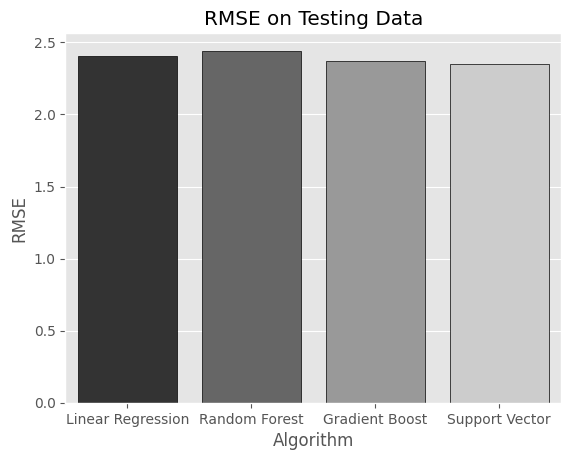

Linear Regression R2 Score: 0.18499442816229372


In [27]:
scaler = StandardScaler().fit(X_train)

rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
sv_model.fit(scaler.transform(X_train), y_train)

rmse_rf = np.sqrt(mean_squared_error(y_test, rf_model.predict(X_test)))
rmse_gb = np.sqrt(mean_squared_error(y_test, gb_model.predict(X_test)))
rmse_sv = np.sqrt(mean_squared_error(y_test, sv_model.predict(scaler.transform(X_test))))

scaled_linear_model = LinearRegression().fit(scaler.transform(X_train), y_train)
linear_r2 = r2_score(y_test, scaled_linear_model.predict(scaler.transform(X_test)))
linear_rmse = np.sqrt(mean_squared_error(y_test, scaled_linear_model.predict(scaler.transform(X_test))))

sns.barplot(x=["Linear Regression", "Random Forest", "Gradient Boost", "Support Vector"], y=[linear_rmse, rmse_rf, rmse_gb, rmse_sv],
            palette="gray", edgecolor="black")
plt.xlabel("Algorithm")
plt.ylabel("RMSE")
plt.title("RMSE on Testing Data")
plt.show()

print(f"Linear Regression R2 Score: {linear_r2}")

Based on these results, the models perform similarly well on the testing data than on cross validation on the training dataset. Based on the R2 Score for Linear Regression, we can estimate that only around 15-20% of the variability in a student's grades can be explained by the given student demographics. This is a lot worse than the Linear Regression on the training dataset from before, showing that we were right and it did overfit.

Finally, we can use the feature importances from the tree-based algorithms and compare them with the Linear Regression feature importances. For the tree-based algorithms, the features that are higher up in the tree are seen as more important, and this can be mathematically measured through Gini Importance. For Linear Regression, after transforming each variable to a Standard Normal Distribution(mean of 0 and standard deviation of 1) and getting each coefficient, the higher coefficients are inherently more important as each feature is standardized.

In order to create a graph that directly compares each feature importance, even if for Linear Regression the scale of feature importances is way different than in Random Forests or Gradient Boosting, we will instead measure each feature importance as its "rank" in importance relative to the other feature importances in the model. For example, if the importances for a model were [0.13, 0.15, 0.11, 0.22], it would be transformed to [3, 4, 1, 2], with the higher "rank" being more important.

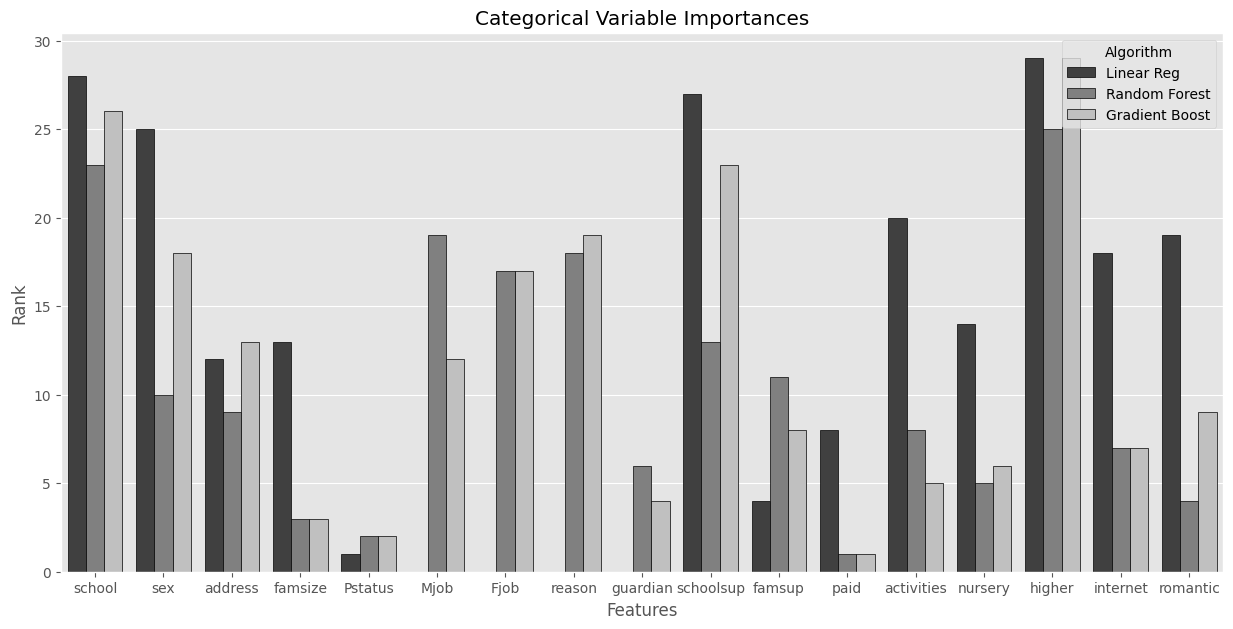

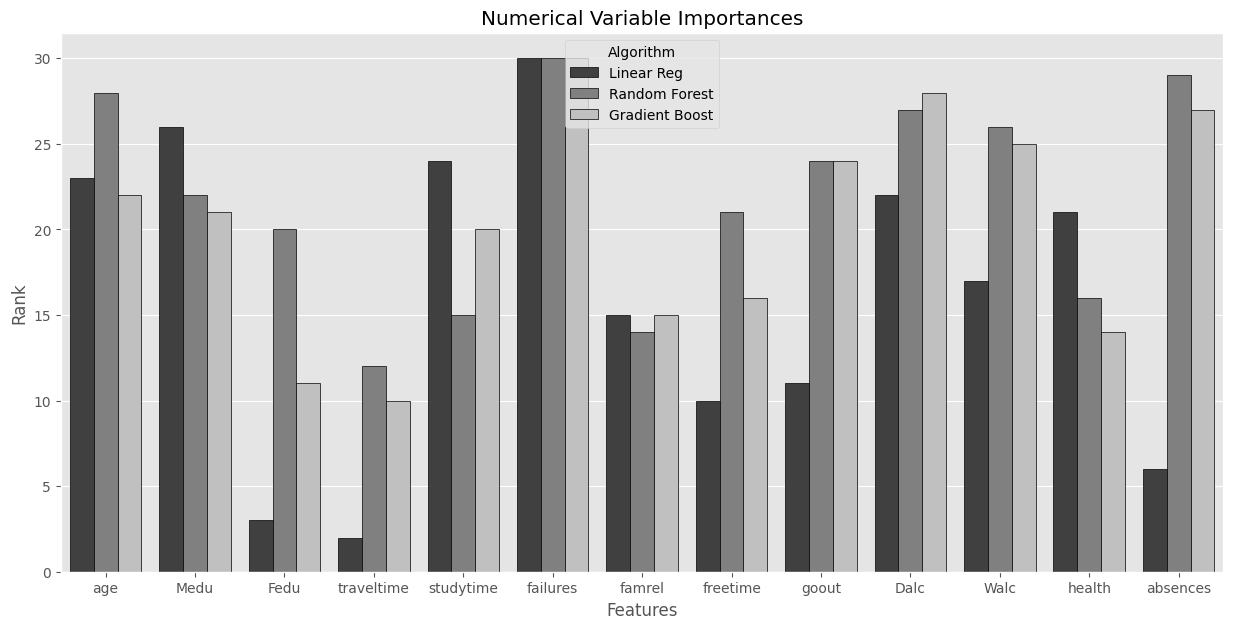

In [28]:
def arr_to_rank(arr):
  return arr.argsort().argsort() + 1

standard_linear = LinearRegression().fit(StandardScaler().fit_transform(X_train), y_train)

features = list(X_train.columns)
standard_coef = arr_to_rank(np.abs(standard_linear.coef_))
rf_coef = arr_to_rank(rf_model.feature_importances_)
gb_coef = arr_to_rank(gb_model.feature_importances_)

def plot_col_coefs(cols, title):

  all_coefs = list(standard_coef) + list(rf_coef) + list(gb_coef)
  all_features = features * 3
  algos = ["Linear Reg" for i in range(len(features))] + ["Random Forest" for i in range(len(features))] + ["Gradient Boost" for i in range(len(features))]

  counter = 0
  for i in range(len(all_features)):
    if all_features[counter] in multi_nominal and algos[counter] == "Linear Reg":
      all_coefs[counter] = 0
    if all_features[counter] not in cols:
      all_coefs.pop(counter)
      all_features.pop(counter)
      algos.pop(counter)
      counter -= 1
    counter += 1

  temp_df = pd.DataFrame({
      "Features":all_features,
      "Rank":all_coefs,
      "Algorithm":algos
  })

  plt.figure(figsize=(15,7))
  sns.barplot(x="Features", y="Rank", hue="Algorithm", data=temp_df, palette="gray", edgecolor="black")
  plt.title(title)
  plt.show()

plot_col_coefs(binary+multi_nominal, "Categorical Variable Importances")
plot_col_coefs(numerical, "Numerical Variable Importances")

When comparing the feature importances for each feature, we can infer possible non-linear relationships in the data along with the impact of confounding variables. We can also take into note how Linear Regression controls for other variables and looks for a linear relationship, while tree-based models do not control for variables and can incorporate non-linear relationships. Some of the variables show interesting patterns:

- Factors such as having a paid job, engaging in extracirricular activites, having access to the internet, etc. are likewise ranked as low importance by both the regression and tree-based models. This reaffirms the idea that factors such as these that are traditionally associated with better grades may not have as much of an impact as one may think.

- Factors like going out, alchohol consumption, and absences are placed as significantly more important in the tree-based models than the Linear-based ones. This could mean two things: either these variables aren't that important when accounting for confounding variables, or there is an important, non-linear relationship between these variables and grades. Looking at the confounding impact graph for Linear Regression(which shows a moderate confounding impact for these variables), it is likely a mixture of both of these.

- Variables like studying time, desire for higher education, and age are highly valued in all of the models, reaffirming that these are the most important factors behind a student's grades, more than things like educational support and extracirriculars. Although studying time and age are highly correlated with some of the other variables(VIF > 5), it can be generally said that maturity and care for school are highly important factors.

### Part 3: Final Conclusion

One of the top priorities of every school is to ensure the acedemic success of their students, which is reflected through their students' grades. Thus, it is vital to understand the factors behind student's grades in order to make policies that will best improve them. This is the motive behind this analysis: to understand which factors affect student's grades, and the next path for schools to take based off of said factors.

A common way schools will attempt to increase their students' acedemic ability is through establishing educational and extracirricular support programs. However, based off of this analysis, it is clear that these have tangible effects on student's grades. Schools should focus on investigating their support programs deeper to see why their students aren't benefitting from it, and should consider other methods for improving grades.

The main finding of this analysis is that the true factors behind a student's grades are a lot more socially based than strictly acedemically based. In short, a student's grades is mainly driven by their maturity and overall dedication for school. Therefore, schools should increase their student's maturity, possibly through social and emotional learning programs and/or leadership development. Schools should increase their student's dedication, possibly by establishing a positive learning culture, providing leadership oppurtunities, and celebrating the acedemic achievements of their students.

Despite all of this, there is still a significant gap in knowledge in what truly affects a student's grades. Even when applying several advanced machine learning models, the given data(which included a student's age, studying time, desire for higher education, and much more) could only explain 15-20% of the variability in grades. More data collection and studies must be conducted to get a deeper understanding for students' acedemic success.